In [452]:
# %load_ext cudf.pandas
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import os
    
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score # To calculate quadratic weighted Kappa
from sklearn.pipeline import Pipeline


from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from lightgbm import LGBMRegressor, LGBMClassifier

from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import clone, BaseEstimator, RegressorMixin

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost import CatBoostRegressor


from scipy.stats import mode
from scipy import stats
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim

running_locally = True
rerun_series = False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [453]:
if running_locally:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    data_dictionary = pd.read_csv('data_dictionary.csv')
else:
    train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [454]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000

# Exploratory Data Analysis

### Severity Impairment Index
First, we'll look at the distribution of `sii` data

In [455]:
sii_data = train_df['sii'].value_counts().reset_index()
sii_data.columns = ['sii_label', 'count']
sii_data['percent_of_total'] = round((sii_data['count'] / len(train_df)) * 100,1)
sii_data
print(f"{sii_data}\n")
print(f"{100.0*train_df['sii'].isnull().sum()/len(train_df):.2f}% of the sii data is null")

   sii_label  count  percent_of_total
0        0.0   1594              40.3
1        1.0    730              18.4
2        2.0    378               9.5
3        3.0     34               0.9

30.91% of the sii data is null


### Demographics
Let's look through the data related to demographics

In [456]:
train_df['Basic_Demos-Sex'].value_counts()

Basic_Demos-Sex
0    2484
1    1476
Name: count, dtype: int64

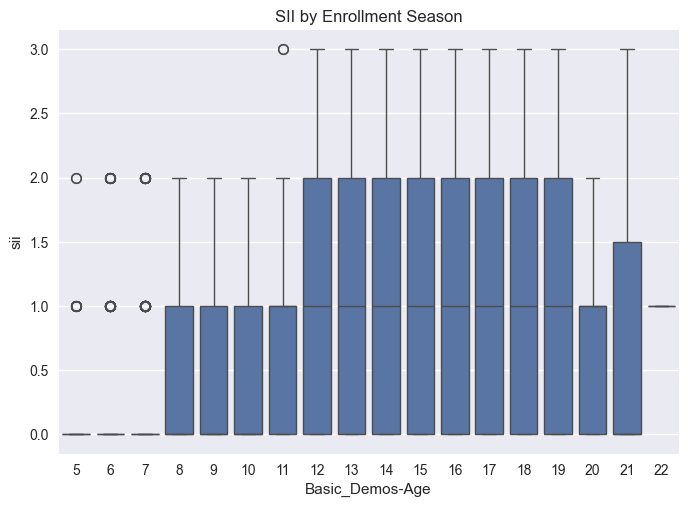

In [457]:
plt.style.use('seaborn-v0_8')
sns.boxplot(x='Basic_Demos-Age', y='sii', data=train_df)
plt.title('SII by Enrollment Season')

plt.show()

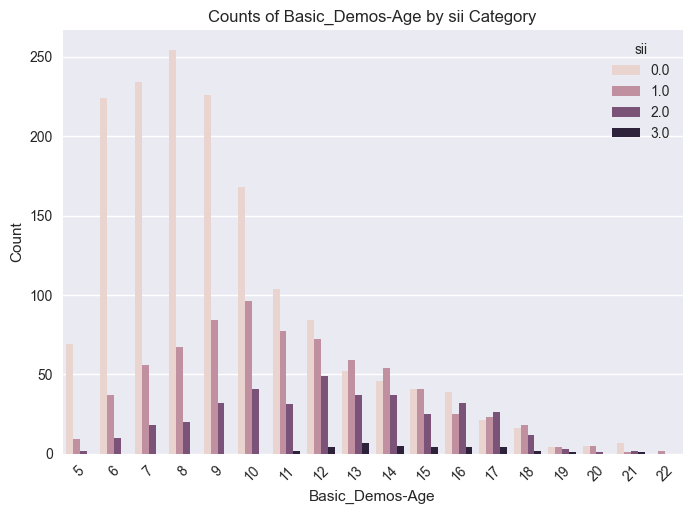

In [458]:
age_sii_counts = train_df.groupby(['Basic_Demos-Age', 'sii']).size().reset_index(name='count')
sns.barplot(data=age_sii_counts, x='Basic_Demos-Age', y='count', hue='sii')
plt.title('Counts of Basic_Demos-Age by sii Category')
plt.xlabel('Basic_Demos-Age')
plt.ylabel('Count')
plt.legend(title='sii')
plt.xticks(rotation=45)
plt.show()

Here's what we learned:
* We learned that our dataset is mostly males, about 63% male to 37% female
* Also, the interquartile range of `sii` increases with older ages. 
* Younger ages are prone to less severe impairment
* The magnitude of the severity changes based on the age in consideration. E.g.
    * 0 risk -> 8 yrs old
    * 1 risk -> 10 yrs old
    * 2 risk -> 12 yrs old
    * 3 risk -> 13 yrs old

Not shown:
* No trend between `Basic_Demos-Enroll_Season` and `sii`

### Children's Global Assessment Scale

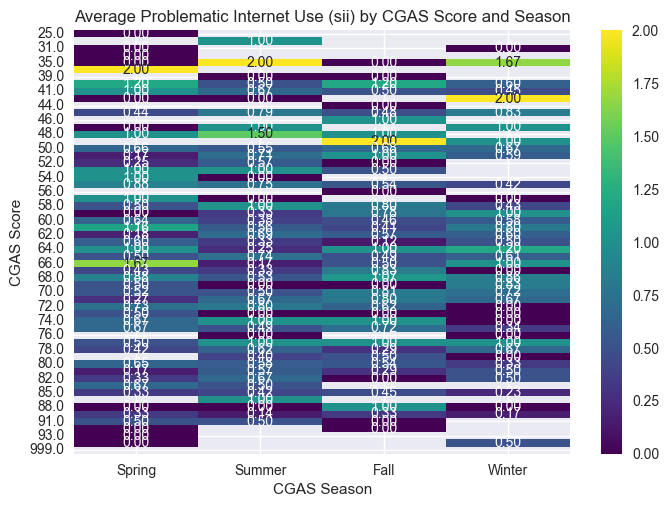

In [459]:
heatmap_data = train_df.groupby(['CGAS-CGAS_Score', 'CGAS-Season'])['sii'].mean().reset_index()
heatmap_data = heatmap_data.pivot(index='CGAS-CGAS_Score', columns='CGAS-Season', values='sii')
column_order = ["Spring", "Summer", "Fall", "Winter"]
heatmap_data = heatmap_data.reindex(columns=column_order) # want the seasons to be in chronological
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f") 
plt.title('Average Problematic Internet Use (sii) by CGAS Score and Season')
plt.xlabel('CGAS Season')
plt.ylabel('CGAS Score')
plt.show()

No notable trends seen in the Children's Global Assessment Scale. Let's move on to the next instrument

### Physical Measures

In [460]:
phys_cols = list(train_df.filter(like='Physical-').columns) + ['sii']
train_df[phys_cols].describe()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,sii
count,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,2736.000000
mean,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,0.580409
std,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,0.771122
min,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000
25%,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,0.000000
50%,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,0.000000
75%,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,1.000000
max,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,3.000000


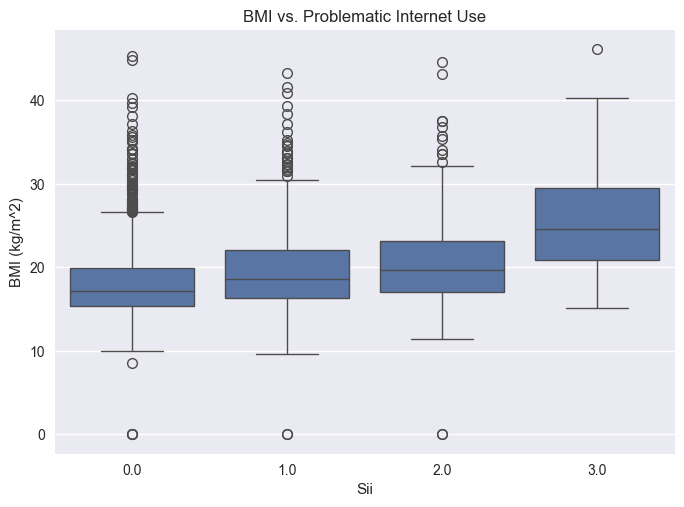

In [461]:
sns.boxplot(x='sii', y='Physical-BMI', data=train_df)
plt.title('BMI vs. Problematic Internet Use')
plt.xlabel('Sii')
plt.ylabel('BMI (kg/m^2)')
plt.show()


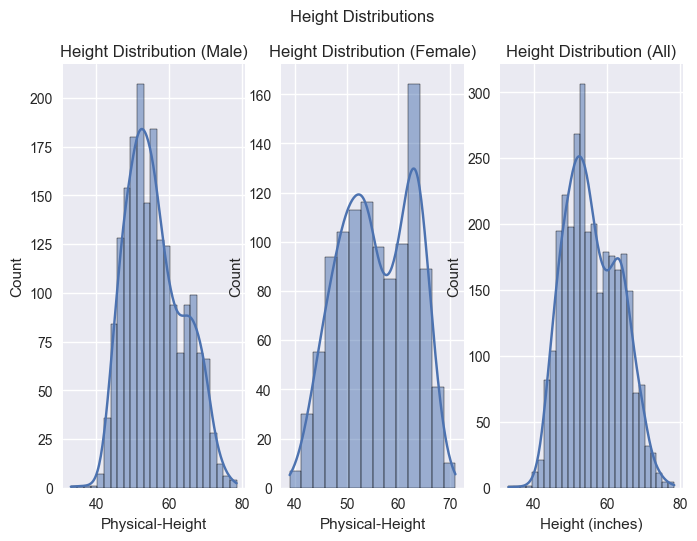

In [462]:
fig, axes = plt.subplots(1, 3)
sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 0]['Physical-Height'], kde=True, ax=axes[0])
axes[0].set_title('Height Distribution (Male)')

sns.histplot(train_df[train_df['Basic_Demos-Sex'] == 1]['Physical-Height'], kde=True, ax=axes[1])
axes[1].set_title('Height Distribution (Female)')

sns.histplot(train_df['Physical-Height'], kde=True, ax=axes[2])
axes[2].set_title('Height Distribution (All)')

plt.suptitle('Height Distributions')
plt.xlabel('Height (inches)')
plt.show()

Here's what we learned: 
- Higher BMI corresponds to higher `sii`. The 50 percentile of BMI for "Severe" sii is higher than the 75 percentile for "Moderate" sii
- There was minimal variance in the season w.r.t. the `sii`
- The distribution of heights seemed to take on the form of a bimodal distribution instead of a typical normal distribution. This is likely because males and females are different heights, so the resulting histogram has 2 peaks. The males are the shorter peak because they are typically shorter in the age range collected in this dataset.

### FitnessGram Vitals and Treadmill

In [463]:
fitness_endurance_cols = list(train_df.filter(like='Fitness_Endurance-').columns) + ['sii']
train_df[fitness_endurance_cols].describe()

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,sii
count,743.000000,740.000000,740.000000,2736.000000
mean,4.989233,7.370270,27.581081,0.580409
std,2.014072,3.189662,17.707751,0.771122
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,6.000000,12.750000,0.000000
50%,5.000000,7.000000,28.000000,0.000000
75%,6.000000,9.000000,43.000000,1.000000
max,28.000000,20.000000,59.000000,3.000000


In [464]:
# Hardcode the columns to avoid the category columns
train_df[['Fitness_Endurance-Max_Stage','Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec','sii']].corr()

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,sii
Fitness_Endurance-Max_Stage,1.000000,0.873138,-0.138393,-0.070589
Fitness_Endurance-Time_Mins,0.873138,1.000000,-0.201425,-0.060628
Fitness_Endurance-Time_Sec,-0.138393,-0.201425,1.000000,0.008701
sii,-0.070589,-0.060628,0.008701,1.000000


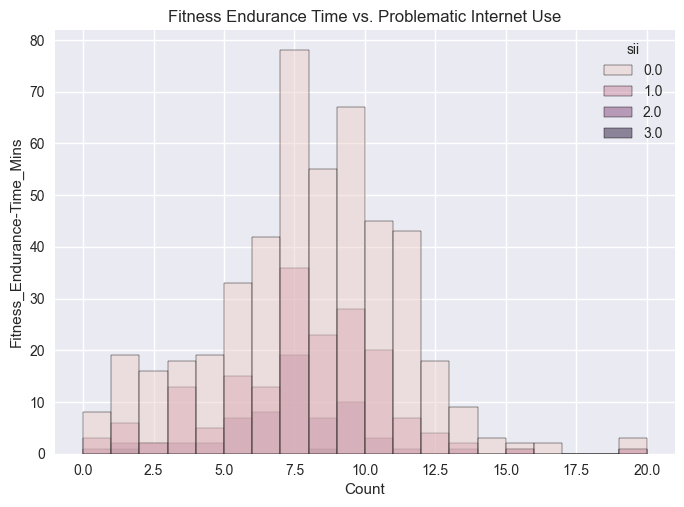

In [465]:
sns.histplot(train_df, x='Fitness_Endurance-Time_Mins',bins=20, hue='sii')
plt.title('Fitness Endurance Time vs. Problematic Internet Use')
plt.xlabel('Count')
plt.ylabel('Fitness_Endurance-Time_Mins')
plt.show()

Here's what we learned:
- `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` should be combined into 1 column. This will be done later
- There wasnt a strong correlation with any of these columns and `sii`

### FitnessGram Child

In [466]:
fgc_cols = list(train_df.filter(like='FGC').columns) + ['sii']
train_df[fgc_cols].describe()

,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,sii
count,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,2736.000000
mean,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,0.580409
std,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,0.771122
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,15.100000,1.000000,16.200000,2.000000,0.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000,0.000000
50%,9.000000,0.000000,20.050000,2.000000,21.200000,2.000000,3.000000,0.000000,9.000000,1.000000,9.000000,1.000000,10.000000,1.000000,0.000000
75%,15.750000,1.000000,26.600000,2.000000,28.175000,2.000000,9.000000,1.000000,11.000000,1.000000,11.000000,1.000000,12.000000,1.000000,1.000000
max,115.000000,1.000000,124.000000,3.000000,123.800000,3.000000,51.000000,1.000000,21.700000,1.000000,21.000000,1.000000,22.000000,1.000000,3.000000


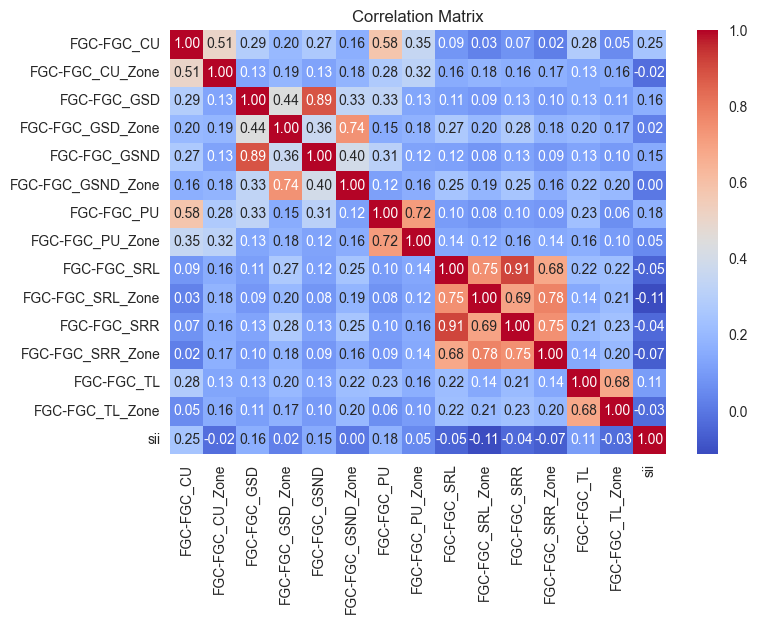

In [467]:
corr_matrix = train_df[fgc_cols].drop(columns=['FGC-Season']).corr()
sorted_cols = corr_matrix.columns.sort_values()
sorted_corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]

sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Here's what we learned:
- Interestingly, there isn't as high of a correlation between the raw values and the categorized "zones". 
    - The highest observed correlation between a category and its zone was only 0.75 for `FGC_FGC_SRR` and `FGC_FGC_SRL`. (These two measurements are just the left and right legs of the Sit & Reach.)

### Bio-electric Impedance Analysis

In [468]:
bia_cols = list(train_df.filter(like='BIA-').columns) + ['sii']
train_df[bia_cols].describe()

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,sii
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,2736.000000
mean,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,0.580409
std,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.771122
min,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.000000
25%,2.000000,2.966905,15.913600,1004.710000,1605.785000,11.109550,49.278100,13.408000,2.306915,8.602395,1.000000,24.463500,12.98315,45.204100,21.141550,35.887000,0.000000
50%,3.000000,3.922720,17.966500,1115.380000,1863.980000,15.928000,61.066200,14.092500,3.698630,16.174600,2.000000,28.855800,16.43880,56.996400,27.415100,44.987000,0.000000
75%,3.000000,5.460925,21.461100,1310.360000,2218.145000,25.162200,81.833800,15.430950,5.987690,30.273100,2.000000,35.475700,22.16760,77.105650,38.179400,60.271050,1.000000
max,5.000000,4115.360000,53.924300,83152.200000,124728.000000,3233.000000,8799.080000,217.771000,28.251500,153.820000,3.000000,2457.910000,3108.17000,4683.710000,3607.690000,5690.910000,3.000000


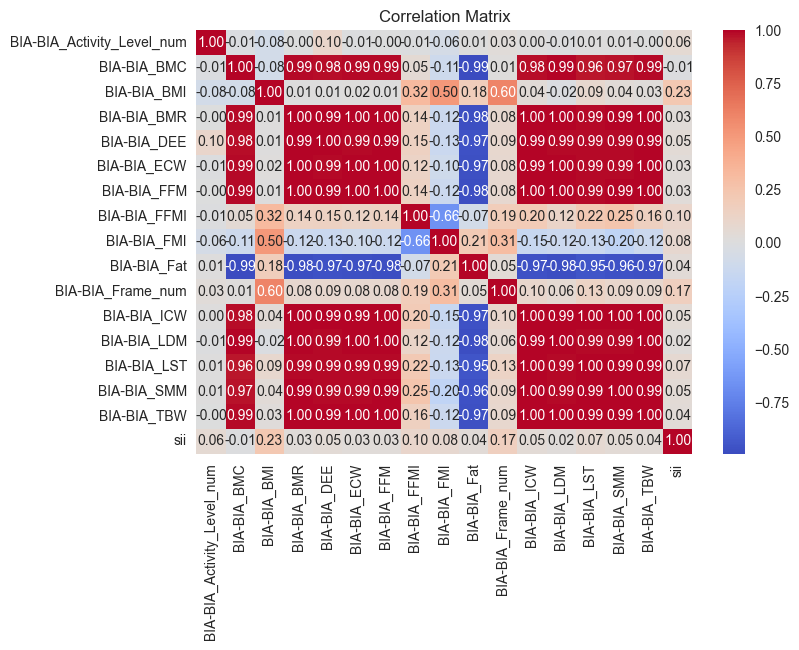

In [469]:
bia_corr_matrix = train_df[bia_cols].drop(columns=['BIA-Season']).corr()
bia_sorted_cols = bia_corr_matrix.columns.sort_values()
bia_sorted_corr_matrix = bia_corr_matrix.loc[bia_sorted_cols, bia_sorted_cols]

sns.heatmap(bia_sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

We can clearly see that there are some highly correlated features. Let's explore that a bit more

In [470]:
pd.set_option('display.max_rows', None)
correlated_bia_features = ['BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_Fat','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW']
all_bia_features = ['BIA-BIA_BMC','BIA-BIA_BMI','BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFM','BIA-BIA_FFMI','BIA-BIA_FMI','BIA-BIA_Fat','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW']

In [471]:
# TODO: uncomment this later
# pairplot_features = correlated_bia_features + ['sii']
# sns.pairplot(train_df[pairplot_features], hue='sii', palette='viridis')

Here's what we learned:
- Body Fat Percentage is inversely correlated to most BIA fields, i.e. Bone Mineral Content, Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, Fat Free Mass, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, Total Body Water.
- Basal Metabolic Rate, Daily Energy Expenditure, Extracellular Water, and Fat Free Mass are all correlated to each other.
- Similarly, Intracellular Water, Lean Dry Mass, Lean Soft Tissue, Skeletal Muscle Mass, and Total Body Water are correlated to each other
- No one attribute correlates to `sii`

### Physical Activity Questionnaire

Text(0.5, 1.0, 'Physical Activity Questionnaire (Children)')

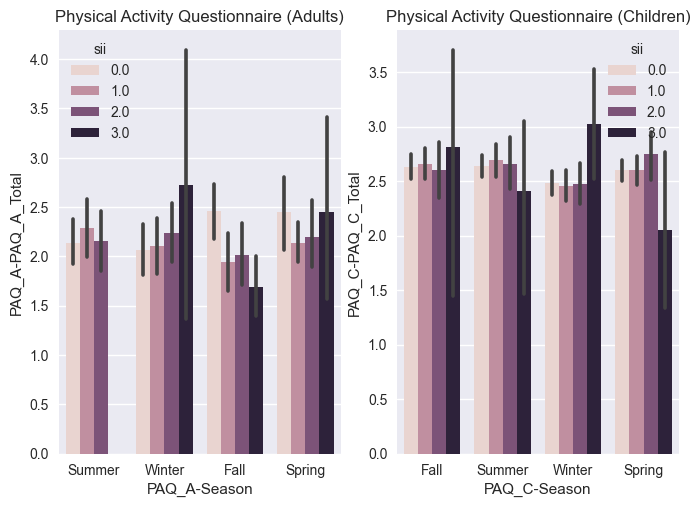

In [472]:
fig, axes = plt.subplots(1,2)
sns.barplot(data=train_df, x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', hue='sii', ax=axes[0])
axes[0].set_title('Physical Activity Questionnaire (Adults)')

sns.barplot(data=train_df, x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', hue='sii', ax=axes[1])
axes[1].set_title('Physical Activity Questionnaire (Children)')

Here's what we learned:
- There are no adults with a "severe" `sii` rating in the Summer.
- Winter was the season with the most "severe" `sii` ratings for children, but it was the season with the fewest "severe" `sii` ratings for adults. 

### Parent-Child Internet Addiction Test

In [473]:
pciat_aggs = train_df.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean'])
pciat_aggs = pciat_aggs.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score', 'mean': 'Average total PCIAT Score'}
)
pciat_aggs

,Minimum PCIAT total Score,Maximum total PCIAT Score,Average total PCIAT Score
sii,,,
0.0,0.0,30.0,13.929737
1.0,31.0,49.0,38.726027
2.0,50.0,79.0,60.658730
3.0,80.0,93.0,85.911765


In [474]:
# List all columns that are of the form PCIAT-PCIAT_XX
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]

pciat_summed_total = train_df[pciat_columns].fillna(0).sum(axis=1)
is_calculated_sum_equal_to_total_column = pciat_summed_total == train_df['PCIAT-PCIAT_Total'].fillna(0)

# Check if sum of the scores equals total for all rows
is_calculated_sum_equal_to_total_column.sum() == len(train_df)


True

Here's what we learned:
- The average of the scores for each `sii` classification was around the median of the bounds of the range (e.g. n `sii` of 0 is from 0-30, and the average score was ~14)
- The sum of the PCIAT scores all align with the classification set by the Severity Impairment Index (sii).
- The number of instances where PCIAT-PCIAT_1 through PCIAT-PCIAT_20 is equal to PCIAT-PCIAT_Total is equal to the number of records in the dataset. This shows that PCIAT-PCIAT_Total is 100% is a linear transformation of other features in this dataset, so we can drop it from the dataset later. However, many of the columns are `nan`. This means that if an entry's sum is 30 but, for instance, there are 10 `nan` values, that record is likely misclassified. We will account for this in the Feature Engineering section.

Also, note that the **test** set does not have any of the PCIAT data, and we're missing about 30% of the `sii` label in the training data. 

### Sleep Disturbance Scale

In [475]:
sds_cols = list(train_df.filter(like='SDS-').columns) + ['sii']
train_df[sds_cols].drop(columns=['sii']).isnull().sum()/train_df[['SDS-Season','SDS-SDS_Total_Raw','SDS-SDS_Total_T']].notnull().sum()

SDS-Season           0.512605
SDS-SDS_Total_Raw    0.517823
SDS-SDS_Total_T      0.519570
dtype: float64

In [476]:
# Hardcode to omit the category columns
train_df[['SDS-SDS_Total_Raw','SDS-SDS_Total_T']].corr()

,SDS-SDS_Total_Raw,SDS-SDS_Total_T
SDS-SDS_Total_Raw,1.000000,0.996134
SDS-SDS_Total_T,0.996134,1.000000


Here's what we learned:
- About half of the sleep data is null
- There is an extremely strong correlation between the Total Raw Score and Total T-score. We will remove one in the Feature Engineering Section

### Internet Use

In [477]:
int_use = list(train_df.filter(like='PreInt_EduHx-').columns) + ['sii']
train_df[int_use].drop(columns='PreInt_EduHx-Season').corr()

,PreInt_EduHx-computerinternet_hoursday,sii
PreInt_EduHx-computerinternet_hoursday,1.000000,0.336526
sii,0.336526,1.000000


Here's what we learned:
- There is a weak correlation between Hours of Using Computer/Internet and `sii`. This is the strongest correlation we have seen so far between a raw column and `sii`.

# Series Data

In [478]:
if rerun_series:
    def process_file(filename, dirname):
        data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
        data.drop('step', axis=1, inplace=True)
        return data.describe().values.reshape(-1), filename.split('=')[1]

    def load_time_series(dirname) -> pd.DataFrame:
        ids = [d for d in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, d))]

        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
        stats, indexes = zip(*results)

        data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
        data['id'] = indexes
        return data

    if running_locally:
        train_ts = load_time_series('./series_train.parquet')
        test_ts = load_time_series('./series_test.parquet')
        random_raw_parquet_file = pd.read_parquet('series_train.parquet/id=0417c91e/part-0.parquet')
    else:
        train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
        test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

    train_ts.to_csv('train_ts.csv', index=False)
    test_ts.to_csv('test_ts.csv', index=False)


In [479]:
if not rerun_series:
    train_ts = pd.read_csv('train_ts.csv')
    test_ts = pd.read_csv('test_ts.csv')

# Data Cleaning and Feature Engineering

Combine `Fitness_Endurance-Time_Mins` and `Fitness_Endurance-Time_Sec` into 1 column

In [480]:
def combine_fe_time_into_one_column(df):
    # check if either column is null
    null_mask = df['Fitness_Endurance-Time_Mins'].isnull() | df['Fitness_Endurance-Time_Sec'].isnull()
    df['Fitness_Endurance-Time'] = df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'] / 60

    # set result to null if either column is null
    df.loc[null_mask, 'Fitness_Endurance-Time'] = np.nan  

    df.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

combine_fe_time_into_one_column(test_df)
combine_fe_time_into_one_column(train_df)

In [481]:
test_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Fitness_Endurance-Time
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,7.550000
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,Summer,6.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,9.616667
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0,NaN
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,NaN,NaN,Fall,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,Fall,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0,NaN
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,NaN,NaN,Fall,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Fall,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0,NaN
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`SDS-SDS_Total_Raw` and `SDS-SDS_Total_T` have a 0.996 correlation. Remove the one smaller effect on the target variable. We can use a Random Forest for this.

In [482]:
model = RandomForestClassifier(random_state=42)
temp_df = train_df[train_df['sii'].notnull()].copy()
temp_df.dropna(subset=['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], inplace=True)
model.fit(temp_df[['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']], temp_df['sii'])

print(*zip(model.feature_importances_, model.feature_names_in_))

(0.5260250697472485, 'SDS-SDS_Total_Raw') (0.47397493025275156, 'SDS-SDS_Total_T')


`SDS-SDS_Total_T` has a smaller effect on the target variable, so we will drop it

In [483]:
def remove_sds_column(df):
    if 'SDS-SDS_Total_T' in df.columns:
        df.drop(columns=['SDS-SDS_Total_T'], inplace=True)
remove_sds_column(train_df)
remove_sds_column(test_df)

### PCIAT
There is a data point with no PCIAT scores but a total value of 0. It has an `PreInt_EduHx-computerinternet_hoursday` of 2, but an `sii` of 0. If over 70% of the PCIAT scores are null, then we cannot rely on the `PCIAT-PCIAT_Total` score, so we null it out.

In [484]:
pciat_component_cols = [f'PCIAT-PCIAT_{i:02}' for i in range(1, 21)]
null_percentage = train_df[pciat_component_cols].isnull().mean(axis=1)

mask = null_percentage > 0.7  # Can adjust this to make it more or less strict
train_df.loc[mask, 'PCIAT-PCIAT_Total'] = np.nan
# No PCIAT columns on test_df, so don't need to transform it

If a record is missing multiple values in the PCIAT evaluations, it could potentially be missing data that would **increase the severity** of the `sii`. The dataset treats those values as 0, but that is not a fair assumption. If there are a sufficient values from a row missing, we should impute the missing values using the average value for that column and re-calculate the `PCIAT-PCIAT_TOTAL` (and subsequently, the `sii`).

In [485]:
# Only operate on rows where the score is already >= 10. With only 20 columns, getting to 30 points to move up in severity won't happen.
temp_pciat_df = train_df[(train_df['PCIAT-PCIAT_Total'] >= 10) & (train_df[pciat_component_cols].isnull().any(axis=1))].copy()

temp_pciat_df_filled = temp_pciat_df[pciat_component_cols].apply(lambda x: x.fillna(x.mean()), axis=0)
temp_pciat_df['PCIAT_Sum_Filled'] = temp_pciat_df_filled.sum(axis=1)

train_df.loc[temp_pciat_df.index, 'PCIAT_Sum_Filled'] = temp_pciat_df['PCIAT_Sum_Filled']

In [486]:
def assign_bucket(value):
    if 0 <= value <= 30:
        return 0
    elif 31 <= value <= 49:
        return 1
    elif 50 <= value <= 79:
        return 2
    elif 80 <= value:
        return 3
    else:
        return np.nan

# Apply the bucket assignment function to both columns
train_df['PCIAT_Sum_Classify_Sii'] = train_df['PCIAT_Sum_Filled'].apply(assign_bucket)

rows_to_be_updated = train_df[train_df['PCIAT_Sum_Classify_Sii'] > train_df['sii']]
print(rows_to_be_updated[['sii', 'PCIAT_Sum_Classify_Sii']])

train_df['sii'] = np.where(
    train_df['PCIAT_Sum_Classify_Sii'] > train_df['sii'],  # Condition
    train_df['PCIAT_Sum_Classify_Sii'],                    # New value if condition is met
    train_df['sii']                                        # Keep existing value otherwise
)

train_df.drop(columns=['PCIAT_Sum_Filled', 'PCIAT_Sum_Classify_Sii'], inplace=True)

      sii  PCIAT_Sum_Classify_Sii
24    0.0                     1.0
270   1.0                     2.0
724   0.0                     1.0
2285  0.0                     1.0
3672  1.0                     2.0


We should also check for outliers and replace them with `NaN`. As an example, `CGAS-CGAS_Score` has a value of 999, which is an error

In [488]:
train_df['BIA-BIA_BMC'].describe()

count    1991.000000
mean        6.719826
std        92.586325
min        -7.789610
25%         2.966905
50%         3.922720
75%         5.460925
max      4115.360000
Name: BIA-BIA_BMC, dtype: float64

In [451]:
def handle_outliers(df, column, valid_min, valid_max, placeholder_value=np.nan):
    outliers = (df[column] < valid_min) | (df[column] > valid_max)
    
    print(f"Found {outliers.sum()} outliers in column '{column}'.")
    
    df.loc[outliers, column] = placeholder_value

def remove_outliers_z_score(df, column, threshold=3):
    data = df[column]
    z_scores = stats.zscore(data)
    outliers = np.abs(z_scores) >= threshold
    num_outliers = np.sum(outliers)
    print(f"Number of outliers found in {column}: {num_outliers}")
    filtered_data = data[~outliers]
    return filtered_data

handle_outliers(train_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(test_df, 'CGAS-CGAS_Score', 0, 100, np.nan)
handle_outliers(train_df, 'SDS-SDS_Total_Raw', 0, 100, np.nan)
handle_outliers(test_df, 'SDS-SDS_Total_Raw', 0, 100, np.nan)

train_df['BIA-BIA_BMC'] = remove_outliers_z_score(train_df, 'BIA-BIA_BMC', threshold=3)
train_df['BIA-BIA_BMI'] = remove_outliers_z_score(train_df, 'BIA-BIA_BMI', threshold=6)

Found 1 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'CGAS-CGAS_Score'.
Found 0 outliers in column 'SDS-SDS_Total_Raw'.
Found 0 outliers in column 'SDS-SDS_Total_Raw'.
Number of outliers found in BIA-BIA_BMC: 0
Number of outliers found in BIA-BIA_BMI: 0


# Impute Missing Data

### Remove Sparse Records

There are a handful of records that are almost entirely null. We will remove these from the training data. However, every record has a value for`id`, `Basic_Demos-Age`, and `Basic_Demos-Sex`. Therefore, if a record has all remaining columns listes as `NaN`, it is safe to drop them from `train_df`. 

In [312]:
pd.set_option('display.max_rows', 10)
print(f"There are {len(train_df.columns)} columns in the training data and {len(test_df.columns)} columns in the test data.\n")
null_counts_per_row = train_df.isnull().sum(axis=1)
null_counts_distribution = null_counts_per_row.value_counts().sort_index()
print(f"Here are the number of null columns each record has:\n {null_counts_distribution}")

There are 80 columns in the training data and 57 columns in the test data.

Here are the number of null columns each record has:
 3     127
4       9
5     109
6     265
7     291
     ... 
72    118
73     78
74    103
75     85
76    199
Name: count, Length: 73, dtype: int64


In [313]:
def drop_mostly_null_rows(df):
    columns_to_check = [col for col in df.columns if 'stat' not in col]
    threshold = 0.10  # require at least 10% of the dataset be non-null return df
    row_threshold = int(threshold * (len(columns_to_check)))
    df.dropna(thresh=row_threshold, subset=columns_to_check, axis=0, inplace=True)
    return df

train_df = drop_mostly_null_rows(train_df)
test_df = drop_mostly_null_rows(test_df)

### Define Feature Interaction Columns

In [415]:
# Can try this. Tests all the combos. Beware the curse of dimensionality
# from itertools import combinations

# columns = all_bia_features # originally used correlated_bia_features
# feature_pairs = list(combinations(columns, 2))
# def create_interaction_features(df):
#     new_features = []
#     for f1, f2 in feature_pairs:
#         new_df = pd.DataFrame()
#         new_df[f'{f1}_x_{f2}'] = df[f1] * df[f2]
#         new_df[f'{f1}_div_{f2}'] = df[f1] / (df[f2] + 1e-5)
#         new_features.append(new_df)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df = pd.concat([df] + new_features, axis=1)
#     return df

# # Apply the function to both train_df and test_df
# train_df = create_interaction_features(train_df)
# test_df = create_interaction_features(test_df)


def feature_engineering(df):
    # df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    # df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    # df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    # df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    # df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    # df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']

    '''
    Here are the top important fields from using all combinations of fields.
    Run the function above and fit the data with an LBGM model to get the feature importances.
    '''
    df['BIA-BIA_ICW_div_BIA-BIA_SMM'] = df['BIA-BIA_ICW'] / (df['BIA-BIA_SMM'] + 1e-5)
    df['BIA-BIA_DEE_div_BIA-BIA_ICW'] = df['BIA-BIA_DEE'] / (df['BIA-BIA_ICW'] + 1e-5)
    df['BIA-BIA_BMI_x_BIA-BIA_DEE'] = df['BIA-BIA_BMI'] * df['BIA-BIA_DEE']
    df['BIA-BIA_ICW_div_BIA-BIA_LDM'] = df['BIA-BIA_ICW'] / (df['BIA-BIA_LDM'] + 1e-5)
    df['BIA-BIA_FFM_div_BIA-BIA_SMM'] = df['BIA-BIA_FFM'] / (df['BIA-BIA_SMM'] + 1e-5)
    df['BIA-BIA_LDM_div_BIA-BIA_SMM']  = df['BIA-BIA_LDM'] / (df['BIA-BIA_SMM'] + 1e-5)

    # handle ratios that result in np.inf
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

2736


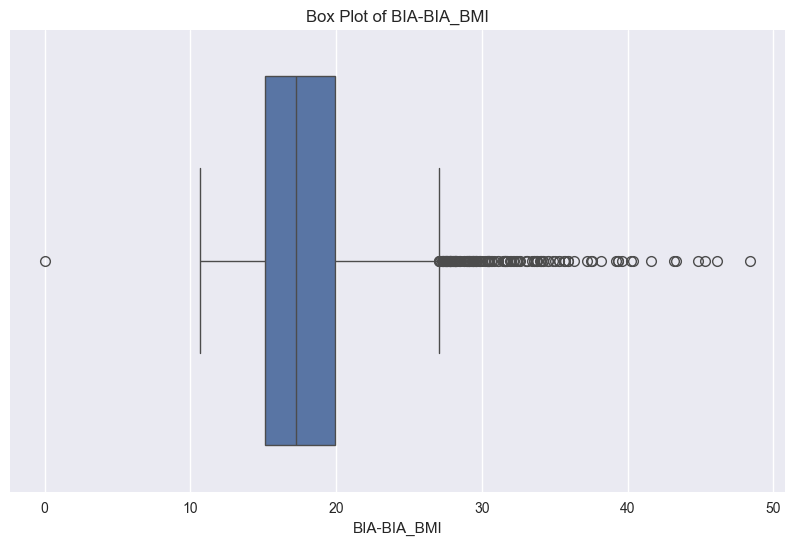

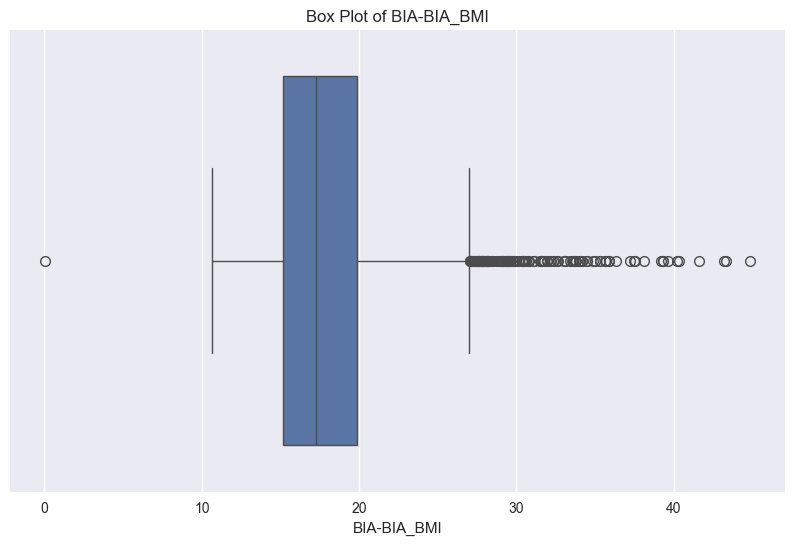

In [376]:
# train_df.describe()

# train_df['BIA-BIA_BMC'] = remove_outliers_z_score(train_df['BIA-BIA_BMC'], threshold=3)
print(f'{train_df['BIA-BIA_BMI'].size}')
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['BIA-BIA_BMI'])
plt.title('Box Plot of BIA-BIA_BMI')
plt.xlabel('BIA-BIA_BMI')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=remove_outliers_z_score(train_df['BIA-BIA_BMI'], threshold=6))
plt.title('Box Plot of BIA-BIA_BMI')
plt.xlabel('BIA-BIA_BMI')
plt.show()

# plt.figure(figsize=(10, 6))
# sns.histplot(train_df['BIA-BIA_FMI'], bins=30, kde=True)
# plt.title('Histogram of BIA-BIA_FMI')
# plt.xlabel('BIA-BIA_FMI')
# plt.ylabel('Frequency')
# plt.show()

### Use k-NN to Impute Missing Numeric, Non-categorical Data

In [316]:
def get_features_numeric_and_non_categorical_features_from_df(df):
    numeric_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
    dd_fields = data_dictionary[data_dictionary['Type'] == 'categorical int']['Field'].tolist()

    # Only normalize numeric columns that are NOT categorical int
    features = [col for col in numeric_columns if col not in dd_fields and col != 'sii']
    return features
# features_to_normalize = get_features_numeric_and_non_categorical_features_from_df(train_df)

In [317]:
def knn_impute(df, n_neighbors=5):
    features_to_impute = get_features_numeric_and_non_categorical_features_from_df(df)
    
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform k-NN imputation and ensure the result integrates with the DataFrame
    imputed_data = imputer.fit_transform(df[features_to_impute])
    df[features_to_impute] = pd.DataFrame(imputed_data, columns=features_to_impute, index=df.index)
    
    return df

train_df = knn_impute(train_df, n_neighbors=5)
test_df = knn_impute(test_df, n_neighbors=5)


### Use k-NN to Impute Missing Numeric, Categorical Data

In [318]:
# Basic_Demos-Sex was removed from this list
numeric_categorical_data = ['FGC-FGC_CU_Zone','FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone','BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num','PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PreInt_EduHx-computerinternet_hoursday']

def knn_impute_categorical(df, categorical_columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Need to check this because test_df doesn't have all the columns as train_df
    valid_columns = [col for col in categorical_columns if col in df.columns]

    # Fit-transform on valid columns
    imputed_data = imputer.fit_transform(df[valid_columns])
    df[valid_columns] = pd.DataFrame(imputed_data, columns=valid_columns, index=df.index)

    df[valid_columns] = df[valid_columns].round().astype(int)
    return df

train_df = knn_impute_categorical(train_df, numeric_categorical_data)
test_df = knn_impute_categorical(test_df, numeric_categorical_data)

# Actigraphy Feature Engineering

In [319]:
# Was getting a kernel error for a bit. Thought you could set the device to 'mps' on Mac, but it didn't work. Set to 'cpu' and it worked, so I left it
mps_device = torch.device("mps")

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled, device='cpu')
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim).to('cpu')
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [320]:
train_ts_no_id = train_ts.drop('id', axis=1)
test_ts_no_id = test_ts.drop('id', axis=1)

if False or not running_locally:
    train_ts_encoded = perform_autoencoder(train_ts_no_id, encoding_dim=50, epochs=100, batch_size=32)
    test_ts_encoded = perform_autoencoder(test_ts_no_id, encoding_dim=50, epochs=100, batch_size=32)

    train_ts_encoded.to_csv('train_ts_encoded.csv', index=False)
    test_ts_encoded.to_csv('test_ts_encoded.csv', index=False)

else:
    train_ts_encoded = pd.read_csv('train_ts_encoded.csv')
    test_ts_encoded = pd.read_csv('test_ts_encoded.csv')

train_ts_encoded["id"] = train_ts["id"]
test_ts_encoded['id'] = test_ts["id"]

train_df = pd.merge(train_df, train_ts_encoded, how="left", on='id')
test_df = pd.merge(test_df, test_ts_encoded, how="left", on='id')



# Create the Model

First, we will define quadratic weighted kappa as our error function and create our train/test split.

In [321]:
def calculate_qwk(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

# Custom scoring function for LGMBRegressor
def qwk_eval(y_pred, data):
    y_true = data.get_label()
    y_pred_rounded = y_pred.round(0).astype(int)
    qwk = calculate_qwk(y_true, y_pred_rounded)
    return 'qwk', qwk, True  # 'qwk' is the name, QWK value, higher is better

def qwk_scorer(estimator, X, y):
    y_pred = estimator.predict(X)  # Get predictions from the estimator
    y_pred_rounded = y_pred.round(0).astype(int)  # Round predictions to integers
    qwk = cohen_kappa_score(y, y_pred_rounded)
    return qwk

# Create a scorer object
# qwk_scorer = make_scorer(qwk_scorer, greater_is_better=True)


In [322]:
# Can't use imputation to predict the value for `sii`, so we drop those that are null
train_df.dropna(subset=['sii'], inplace=True)

X = train_df.drop(columns=['sii','id'])
y = train_df['sii']
# Need to drop all the PCIAT-PCIAT_# columns because they are not given in the test data
X = X.drop(columns=[col for col in X.columns if 'PCIAT' in col])

test_df_ids = test_df['id']
test_df = test_df.drop(columns=['id'])

Define one-hot encoding of seasonal data

In [323]:
season_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
def one_hot_encode_seasons(train_df, test_df):    
    for col in season_columns:
        
        if col in train_df.columns and col in test_df.columns:
            all_categories = sorted(pd.concat([train_df[col], test_df[col]], axis=0).dropna().unique())
            
            train_dummies = pd.get_dummies(train_df[col], prefix=col).reindex(columns=[f"{col}_{cat}" for cat in all_categories], fill_value=0)
            test_dummies = pd.get_dummies(test_df[col], prefix=col).reindex(columns=[f"{col}_{cat}" for cat in all_categories], fill_value=0)

            train_df = pd.concat([train_df, train_dummies], axis=1)
            test_df = pd.concat([test_df, test_dummies], axis=1)

            # Drop the original column
            train_df.drop(col, axis=1, inplace=True)
            test_df.drop(col, axis=1, inplace=True)
    return train_df, test_df

def categorical_encode_seasons(train_df, test_df):
    for col in season_columns:
        if col in train_df.columns and col in test_df.columns:
            train_df[col] = train_df[col].fillna('Missing')
            test_df[col] = test_df[col].fillna('Missing')
            train_df[col] = train_df[col].astype('category')
            test_df[col] = test_df[col].astype('category')

            le = LabelEncoder() # use same encoder for both train and test
            train_df[col] = le.fit_transform(train_df[col])
            test_df[col] = le.transform(test_df[col])

    return train_df, test_df
# Don't want to one-hot encode the original datasets, so we make a copy
X, test_df = categorical_encode_seasons(X, test_df)

In [324]:
def threshold_rounder(oof_non_rounded, thresholds):
    """
    Rounds predictions to the nearest class based on thresholds.
    """
    output = np.zeros_like(oof_non_rounded, dtype=int)
    for i, threshold in enumerate(thresholds):
        output[oof_non_rounded >= threshold] = i + 1
    return output

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluates predictions using quadratic weighted kappa.
    """
    rounded_preds = threshold_rounder(oof_non_rounded, thresholds)
    return -calculate_qwk(y_true, rounded_preds)

### Ensemble method

Need to impute missing data. Only 996 records in the training data have actigraphy data, so we need to impute the missing values. Not all algorithms in the ensemble method can handle nulls.

In [271]:
def impute_missing_enc_data(df):
    imputer = KNNImputer(n_neighbors=5)
    enc_columns = [col for col in df.columns if 'Enc' in col]
    df[enc_columns] = imputer.fit_transform(df[enc_columns])
    return df

X = impute_missing_enc_data(X)
test_df = impute_missing_enc_data(test_df)


If you need to tune some hyperparameters, use GridSearch or RandomSearch

In [272]:
# cb = CatBoostRegressor(random_state=42)
# cat_params = {
#     'iterations': [200],  # Number of boosting iterations
#     'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
#     'depth': [4, 6, 8],  # Depth of trees
#     'l2_leaf_reg': [1, 3, 5, 7, 15],  # L2 regularization coefficient
#     'border_count': [32, 64, 128, 254],  # Number of splits for numerical features
#     'bagging_temperature': [0, 0.5, 1],  # Controls intensity of bagging
# }

# random_search = RandomizedSearchCV(
#     estimator=cb,
#     param_distributions=cat_params,
#     n_iter=10,  # Number of parameter settings to sample
#     scoring='neg_mean_squared_error',  # Or another suitable metric
#     cv=5,  # Number of cross-validation folds
#     n_jobs=-1,  # Use all available CPU cores
#     random_state=42,  # Set a random seed for reproducibility
#     verbose=2  # Print details about the search process
# )

# random_search.fit(X, y)

# Get the best parameters and best estimator
# best_params = random_search.best_params_
# best_estimator = random_search.best_estimator_



In [273]:
# cv_results = random_search.cv_results_
# results_df = pd.DataFrame(cv_results)
# sorted_results_df = results_df.sort_values(by='mean_test_score', ascending=True)
# top_5_results = sorted_results_df.head(5)
# for i, row in top_5_results.iterrows():
#     print(f"Rank {i+1}:")
#     print(f"Mean Test Score: {row['mean_test_score']}")
#     print(f"Parameters: {row['params']}")
#     print()

# cat_params = {
#     'iterations': 200,
#     'learning_rate': 0.05,
#     'depth': 6,
#     'l2_leaf_reg': 15,
#     'border_count': 128,
#     'bagging_temperature': 0.5
# }


Apply the best parameters to each of the models

In [274]:
rf_params = {
    'n_estimators': 200,
    'max_depth': 5,
    'min_samples_split': 2,
    # 'min_samples_leaf': 2,
}

xgb_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'reg_alpha': 0.5,
    'reg_lambda': 1 
}

gb_params = {
    'n_estimators': 200,
    'subsample': 1.0,
    'min_samples_split': 10, 
    'min_samples_leaf': 2,
    'max_features': None,
    'max_depth': 7,
    'learning_rate': 0.2
}

lgb_params = {
    'n_estimators': 100,
    'num_leaves': 33,       
    'subsample': 0.6,       
    'reg_lambda': 0.5,      
    'reg_alpha': 0.5,       
    'min_child_samples': 10,
    'max_depth': -1,        
    'learning_rate': 0.1,   
    'colsample_bytree': 0.8,
    'verbose': -1
}

ridge_params = {
    'alpha': 0.1,
    'solver': 'auto',
    'tol': 1e-3,
    'fit_intercept': True,
}
knn_params = {
    'n_neighbors': 9
}

cat_params = {
    'iterations': 200,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 15,
    'bagging_temperature': 0.5,
    'verbose': 0,
}


In [275]:
n_splits = 5

SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

def qwk_objective(preds, dtrain):
    true = dtrain.get_label()
    preds = np.clip(preds, 0, len(np.unique(true)) - 1)  # Clip predictions
    qwk = calculate_qwk(true, preds.round())
    grad = -2 * (true - preds)  # Placeholder gradient
    hess = 2 * np.ones_like(true)  # Placeholder Hessian
    return grad, hess


models = [
    ("rf", RandomForestRegressor(**rf_params, random_state=42)),
    # ("gb", GradientBoostingRegressor(**gb_params, random_state=42)),
    
    ("xgb", XGBRegressor(**xgb_params, random_state=42)),
    ("lgb", LGBMRegressor(**lgb_params, random_state=42)),
    # ("ridge", Ridge(**ridge_params, random_state=42)),
    # ("knn", KNeighborsClassifier(**knn_params)),
    ("cat", CatBoostRegressor(random_state=42, verbose=0))

]

train_scores = {name: [] for name, _ in models}
val_scores = {name: [] for name, _ in models}


train_S = []
test_S = []

oof_non_rounded = np.zeros(len(y), dtype=float)
test_preds_per_model = np.zeros((len(test_df), len(models), n_splits))

for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Fold", total=n_splits)):
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
    fold_val_preds = np.zeros((len(y_val), len(models)))

    for model_idx, (name, model) in enumerate(models):
        print(f"Training model: {name} on Fold {fold + 1}")
        if model == 'lgb':
            model.fit(X_train, y_train, eval_metric=qwk_eval)
        else:
            model.fit(X_train, y_train)

        train_score = calculate_qwk(y_train, model.predict(X_train).round(0).astype(int))
        train_scores[name].append(train_score)

        val_score = calculate_qwk(y_val, model.predict(X_val).round(0).astype(int))
        val_scores[name].append(val_score)

        fold_val_preds[:, model_idx] = model.predict(X_val)

        # Test predictions for this model
        test_preds_per_model[:, model_idx, fold] = model.predict(test_df)
    
    # Average predictions across models for validation
    y_val_pred_ensemble = fold_val_preds.mean(axis=1)
    oof_non_rounded[test_idx] = y_val_pred_ensemble

    # Calculate metrics for each fold
    train_kappa = calculate_qwk(y_train, model.predict(X_train).round(0).astype(int))
    val_kappa = calculate_qwk(y_val, y_val_pred_ensemble.round(0).astype(int))


    train_S.append(train_kappa)
    test_S.append(val_kappa)
    print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

final_test_preds = test_preds_per_model.mean(axis=2).mean(axis=1)


initial_thresholds = np.quantile(oof_non_rounded, [0.25, 0.5, 0.75])
optimizer = minimize(evaluate_predictions, x0=initial_thresholds, args=(y, oof_non_rounded), method='Nelder-Mead')
thresholds = optimizer.x if optimizer.success else [0.5, 1.5, 2.5]


print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

# for name in train_scores.keys():
#     plt.plot(range(1, n_splits + 1), train_scores[name], marker='o', label=f'{name} - Train')
#     plt.plot(range(1, n_splits + 1), val_scores[name], marker='o', linestyle='--', label=f'{name} - Validation')

# plt.title("Learning Curve: QWK Across Folds")
# plt.xlabel("Fold")
# plt.ylabel("QWK Score")
# plt.legend()
# plt.grid()
# plt.show()


Training Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: rf on Fold 1
Training model: xgb on Fold 1
Training model: lgb on Fold 1
Training model: cat on Fold 1


Training Fold:  20%|██        | 1/5 [00:08<00:33,  8.40s/it]

Fold 1 - Train QWK: 0.9508, Validation QWK: 0.3414
Training model: rf on Fold 2
Training model: xgb on Fold 2
Training model: lgb on Fold 2
Training model: cat on Fold 2


Training Fold:  40%|████      | 2/5 [00:16<00:25,  8.46s/it]

Fold 2 - Train QWK: 0.9485, Validation QWK: 0.4264
Training model: rf on Fold 3
Training model: xgb on Fold 3
Training model: lgb on Fold 3
Training model: cat on Fold 3


Training Fold:  60%|██████    | 3/5 [00:25<00:17,  8.51s/it]

Fold 3 - Train QWK: 0.9484, Validation QWK: 0.4424
Training model: rf on Fold 4
Training model: xgb on Fold 4
Training model: lgb on Fold 4
Training model: cat on Fold 4


Training Fold:  80%|████████  | 4/5 [00:33<00:08,  8.44s/it]

Fold 4 - Train QWK: 0.9541, Validation QWK: 0.3851
Training model: rf on Fold 5
Training model: xgb on Fold 5
Training model: lgb on Fold 5
Training model: cat on Fold 5


Training Fold: 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]

Fold 5 - Train QWK: 0.9506, Validation QWK: 0.3882
Mean Train QWK --> 0.9505
Mean Validation QWK ---> 0.3967


In [ ]:
# oof_tuned = threshold_rounder(oof_non_rounded, thresholds)
# test_predictions = threshold_rounder(final_test_preds, thresholds)

# submission = pd.DataFrame({
#     'id': test_df_ids.values,
#     'sii': test_predictions
# })
# submission.to_csv('submission.csv', index=False)


### Use VotingRegressor

Find the optimal weights for the models in the VR

In [ ]:
# models = [
#     ("rf", RandomForestRegressor(**rf_params, random_state=42)),
#     ("xgb", XGBRegressor(**xgb_params, random_state=42)),
#     ("lgb", LGBMRegressor(**lgb_params, random_state=42)),
#     ("cat", CatBoostRegressor(random_state=42, verbose=0))
# ]

# param_grid = {
#     'weights': [[0.2, 0.3, 0.4, 0.5], [0.3, 0.4, 0.5, 0.5], [0.2, 0.1, 0.3, 0.5]]
# }

# grid_search = GridSearchCV(
#     estimator=VotingRegressor(estimators=models),
#     param_grid=param_grid,
#     scoring=qwk_scorer,
#     cv=5
# )

# grid_search.fit(X, y)
# best_weights = grid_search.best_params_['weights']


In [ ]:
# cv_results = grid_search.cv_results_

# results_df = pd.DataFrame(cv_results)

# sorted_results_df = results_df.sort_values(by='mean_test_score', ascending=False)
# top_5_results = sorted_results_df.head(5)

# for i, row in top_5_results.iterrows():
#     print(f"Rank {i+1}:")
#     print(f"Mean Test Score: {row['mean_test_score']}")
#     print(f"Parameters: {row['params']}")
#     print()

# '''
# Rank 3:
# Mean Test Score: 0.26747842506317276
# Parameters: {'weights': [0.2, 0.1, 0.3, 0.5]}

# Rank 1:
# Mean Test Score: 0.2654634924878301
# Parameters: {'weights': [0.2, 0.3, 0.4, 0.5]}

# Rank 2:
# Mean Test Score: 0.26280321158627523
# Parameters: {'weights': [0.3, 0.4, 0.5, 0.5]}

# '''

Rank 3:
Mean Test Score: 0.26747842506317276
Parameters: {'weights': [0.2, 0.1, 0.3, 0.5]}

Rank 1:
Mean Test Score: 0.2654634924878301
Parameters: {'weights': [0.2, 0.3, 0.4, 0.5]}

Rank 2:
Mean Test Score: 0.26280321158627523
Parameters: {'weights': [0.3, 0.4, 0.5, 0.5]}



In [ ]:
# n_splits = 5

# SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Define models for VotingRegressor
# models = [
#     ("rf", RandomForestRegressor(**rf_params, random_state=42)),
#     ("xgb", XGBRegressor(**xgb_params, random_state=42)),
#     ("lgb", LGBMRegressor(**lgb_params, random_state=42)),
#     ("cat", CatBoostRegressor(random_state=42, verbose=0))
# ]

# # Create VotingRegressor
# voting_model = VotingRegressor(estimators=models, weights=[0.2, 0.2, 0.4, 0.5])

# train_S = []
# test_S = []

# oof_non_rounded = np.zeros(len(y), dtype=float)
# test_preds_per_fold = np.zeros((len(test_df), n_splits))

# for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Fold", total=n_splits)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
#     print(f"Training VotingRegressor on Fold {fold + 1}")
    
#     # Train VotingRegressor
#     voting_model.fit(X_train, y_train)
    
#     # Train score
#     train_score = calculate_qwk(y_train, voting_model.predict(X_train).round(0).astype(int))
#     train_S.append(train_score)
    
#     # Validation score
#     val_preds = voting_model.predict(X_val)
#     val_score = calculate_qwk(y_val, val_preds.round(0).astype(int))
#     test_S.append(val_score)
    
#     # Save predictions for validation and test
#     oof_non_rounded[test_idx] = val_preds
#     test_preds_per_fold[:, fold] = voting_model.predict(test_df)
    
#     print(f"Fold {fold+1} - Train QWK: {train_score:.4f}, Validation QWK: {val_score:.4f}")

# # Final ensemble predictions
# final_test_preds = test_preds_per_fold.mean(axis=1)

# # Optimize thresholds
# initial_thresholds = np.quantile(oof_non_rounded, [0.25, 0.5, 0.75])
# optimizer = minimize(evaluate_predictions, x0=initial_thresholds, args=(y, oof_non_rounded), method='Nelder-Mead')
# thresholds = optimizer.x if optimizer.success else [0.5, 1.5, 2.5]

# print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
# print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")


Training Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training VotingRegressor on Fold 1


Training Fold:  20%|██        | 1/5 [00:09<00:38,  9.65s/it]

Fold 1 - Train QWK: 0.8917, Validation QWK: 0.3773
Training VotingRegressor on Fold 2


Training Fold:  40%|████      | 2/5 [00:18<00:27,  9.28s/it]

Fold 2 - Train QWK: 0.8888, Validation QWK: 0.4310
Training VotingRegressor on Fold 3


Training Fold:  60%|██████    | 3/5 [00:27<00:18,  9.16s/it]

Fold 3 - Train QWK: 0.8836, Validation QWK: 0.4436
Training VotingRegressor on Fold 4


Training Fold:  80%|████████  | 4/5 [00:36<00:09,  9.12s/it]

Fold 4 - Train QWK: 0.8947, Validation QWK: 0.4083
Training VotingRegressor on Fold 5


Training Fold: 100%|██████████| 5/5 [00:46<00:00,  9.22s/it]

Fold 5 - Train QWK: 0.8948, Validation QWK: 0.3647
Mean Train QWK --> 0.8907
Mean Validation QWK ---> 0.4050


In [ ]:
# oof_tuned = threshold_rounder(oof_non_rounded, thresholds)
# test_predictions = threshold_rounder(final_test_preds, thresholds)

# submission = pd.DataFrame({
#     'id': test_df_ids.values,
#     'sii': test_predictions
# })
# submission.to_csv('submission.csv', index=False)


In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# X_poly = poly.fit_transform(X, y)


In [ ]:
# feature_names = poly.get_feature_names_out(input_features=X.columns)
# X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
# interaction_terms = [col for col in X_poly_df.columns if ' ' in col]  # Select columns with interaction terms
# X_interaction = X_poly_df[interaction_terms]
# X_interaction.shape

(2736, 7381)

In [325]:
model = lgb.LGBMClassifier()
model.fit(X, y)


LGBMClassifier()

In [ ]:
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)
top_features = importance_df.head(100)
top_features


### TODO: 
Use neural-interaction-detection to determine more feature interaction
    https://github.com/mtsang/neural-interaction-detection/blob/master/demo.ipynb
    https://medium.com/analytics-vidhya/interaction-effects-in-machine-learning-c8374a9e62dc

